In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mmctools.wrf.utils import tsout_seriesReader
import glob
from mmctools.helper_functions import theta as calc_theta
from os import path
from mmctools.helper_functions import theta_to_T
from mmctools.helper_functions import calc_uv
from mmctools.helper_functions import w_s

***
# Before you run!
<div class="alert alert-block alert-info">
<b>Make sure you have extracted the ICBC data </b>

Run the 1_IdealizedFINOForcing.ipynb notebook

</div>

***

# Functions needed in this script:

In [4]:
def checkType(varn,var,expected_type):
    if var is not None:
        if expected_type is str:
            expected_type = [expected_type]
        if type(expected_type) is not list:
            raise ValueError('expected_type must be list')
        if type(var) not in expected_type:
            raise ValueError('{} must be of type: {}'.format(varn,expected_type))
        
def checkSpecified(varns):
    bad_specified_vars = []
    for varn in varns:
        if varns[varn] is None: bad_specified_vars += [varn]
    if len(bad_specified_vars) > 0:
        raise ValueError("Please specify all of {}".format(bad_specified_vars))
        
def CreateInputSoil(new_file_name=None,
                    z=None,
                    skin_T=None,
                    bottom_T=None,
                    T=None,
                    soilQ=None,
                    use_default=False):
    
    if use_default:
        z=[0.05,0.25,0.75,1.5]
        skin_T=288.0
        bottom_T=288.0
        T=[288.0,288.0,288.0,288.0]
        soilQ=[0.25,0.25,0.25,0.25]
        
    checkSpecified(locals())
        
    checkType('z',z,[type([]),type(np.asarray([]))])
    checkType('skin_T',skin_T,[int,float,np.float64])
    checkType('bottom_T',bottom_T,[int,float,np.float64])
    checkType('T',T,[type([]),type(np.asarray([]))])
    checkType('soilQ',soilQ,[type([]),type(np.asarray([]))])
    
    # Create input file:
    new_f = open(new_file_name,'w')
    line_fmt = '{0:<9.7f}\t{1:<9.5f}\t{2:<9.5f}\n'
    if z[0] != 0.0:
        sfc_z = 0.0
        if skin_T is None: raise ValueError('First z level must be 0.0 if skin_T is not specified')
        if bottom_T is None: bottom_T = T[-1]
        z = np.concatenate([[0.0],z])
        T = np.concatenate([[skin_T],T])
        soilQ = np.concatenate([[bottom_T],soilQ])
        
    for kk,lvl in enumerate(z):
        line = line_fmt.format(lvl,T[kk],soilQ[kk])
        new_f.write(line)
    new_f.close()
        
        
def CreateInputSounding(new_file_name=None,
                        z=None,
                        sfc_T=None,
                        sfc_Q=None,
                        sfc_P=None,
                        sfc_U=None,
                        sfc_V=None,
                        U=None,
                        V=None,
                        T=None,
                        Q=None):

    varns = locals()
    vars_to_not_check = ['sfc_T','sfc_U','sfc_V','sfc_Q']
    for varn in vars_to_not_check:
        del varns[varn]

    checkSpecified(varns)

    checkType('z',z,[type([]),type(np.asarray([]))])
    checkType('sfc_P',sfc_P,[int,float])
    checkType('T',T,[type([]),type(np.asarray([]))])
    checkType('U',U,[type([]),type(np.asarray([]))])
    checkType('V',V,[type([]),type(np.asarray([]))])
    checkType('Q',Q,[type([]),type(np.asarray([]))])
    
    if not ((len(U) == len(V)) and (len(U) == len(T)) and (len(U) == len(Q)) and (len(U) == len(z))):
        raise ValueError('z, U, V, T, and Q must all be the same length')
    
    if z[0] == 0.0:
        if sfc_T is not None: T[0] = sfc_T; print('Overwriting surface T with specified value')
        if sfc_U is not None: U[0] = sfc_U; print('Overwriting surface U with specified value')
        if sfc_V is not None: V[0] = sfc_V; print('Overwriting surface V with specified value')
        if sfc_Q is not None: Q[0] = sfc_Q; print('Overwriting surface Q with specified value')
    else:
        if (sfc_T is None) or (sfc_U is None) or (sfc_V is None) or (sfc_Q is None):
            raise ValueError('First value of z must be 0.0, or sfc variables must be specified')
        else:
            z = [0.0] + list(z)
            T = [sfc_T] + list(T)
            Q = [sfc_Q] + list(Q)
            U = [sfc_U] + list(U)
            V = [sfc_V] + list(V)
    
    # Create input file:
    new_f = open(new_file_name,'w')
    line_fmt = '{0:<2.1f} {1:<4.2f} {2:<4.2f} {3:<4.2f} {4:<6.5f}'
    for kk,lvl in enumerate(z):
        line = line_fmt.format(lvl,U[kk],V[kk],T[kk],Q[kk])
        if kk == 0: line += ' {0:2.1f}'.format(sfc_P)
        line += '\n'
        new_f.write(line)
    new_f.close()
        
        
def checkDimensions(varns):
    dims = []
    return_varns = varns.copy()
    for vv,varn in enumerate(varns):
        dim = len(np.shape(varn))
        dims += [dim]
        if dim == 1: 
            varns[vv] = np.asarray([varn])
    dims = np.unique(dims)
    if len(dims) != 1: raise ValueError('Dimensions must be equal')
    return(varns)

    
        
def CreateForcingFile(new_file_name=None,
                      z=None,
                      Ug=None,
                      Vg=None,
                      W=None,
                      u_tend=None,
                      v_tend=None,
                      T_tend=None,
                      Q_tend=None,
                      datetime=None):

    varns = locals()
    #checkSpecified(varns)
        
    varn_dict = {'z':{'data':z,'dtype':[list,np.ndarray]},
                 'W':{'data':W,'dtype':[list,np.ndarray]},
                 'Ug':{'data':Ug,'dtype':[list,np.ndarray]},
                 'Vg':{'data':Vg,'dtype':[list,np.ndarray]},
                 'u_tend':{'data':u_tend,'dtype':[list,np.ndarray]},
                 'v_tend':{'data':v_tend,'dtype':[list,np.ndarray]},
                 'T_tend':{'data':T_tend,'dtype':[list,np.ndarray]},
                 'Q_tend':{'data':Q_tend,'dtype':[list,np.ndarray]},
                 'datetime':{'data':datetime,'dtype':[str,list,np.ndarray,pd.Timestamp]},
                }

    have_tendencies = False
    if (u_tend is not None) and (v_tend is not None) and (T_tend is not None) and (q_tend is not None):
        have_tendencies = True
    
    for varn in varn_dict:
        checkType(varn,varn_dict[varn]['data'],varn_dict[varn]['dtype'])

    if not ((len(Ug) == len(Vg)) and (len(Ug) == len(W))):
        raise ValueError('Ug, Vg, and W must all be the same length')
    if have_tendencies:
        if not ((len(Ug) == len(u_tend)) and (len(Ug) == len(v_tend))):
            raise ValueError('u_tend and v_tend must all be the same length')
        if not ((len(Ug) == len(T_tend)) and (len(Ug) == len(Q_tend))):
            raise ValueError('T_tend and Q_tend must all be the same length')

    if len(np.shape(z)) == 1:
        constant_z = True
    else:
        constant_z = False

    if type(z) is not np.ndarray: z = np.asarray(z)
    #if constant_z:
    #    if z[0] != 0.0: raise ValueError('First level must be the surface')
    #else:
        
    
    # Create forcing file:
    
    if (type(datetime) is str) or (type(datetime) is pd.Timestamp): datetime = [datetime]
    
    if have_tendencies:
        Ug,Vg,W,u_tend,v_tend,T_tend,Q_tend = checkDimensions([Ug,Vg,W,u_tend,v_tend,T_tend,Q_tend])
    else:
        Ug,Vg,W = checkDimensions([Ug,Vg,W])

    if type(Ug) is list: Ug = np.array(Ug)
    if type(Vg) is list: Vg = np.asarray(Vg)
    if type(W) is list: W = np.asarray(W)
    if have_tendencies:
        if type(u_tend) is list: u_tend = np.asarray(u_tend)
        if type(v_tend) is list: v_tend = np.asarray(v_tend)
        if type(T_tend) is list: T_tend = np.asarray(T_tend)
        if type(Q_tend) is list: Q_tend = np.asarray(Q_tend)

    new_f = open(new_file_name,'w')
    if have_tendencies:
        line_fmt = '{0:<3.2f} {1:<3.2f} {2:<3.2f} {3:<6.5f} {4:<6.5f} {5:<6.5f} {6:<6.5f} {7:<10.9f}\n'
    else:
        line_fmt = '{0:<3.2f} {1:<3.2f} {2:<3.2f} {3:<6.5f}\n'
        

    for dd,dtime in enumerate(datetime):
        if type(dtime) is str: dtime = pd.to_datetime(dtime)
        dtime_str = str(dtime).replace(' ','_').replace('T','_').split('.')[0]
        new_f.write(dtime_str + '\n')
        if constant_z:
            lvls = z
        else:
            lvls = z[dd,:]
        for kk,lvl in enumerate(lvls):
            if have_tendencies:
                line = line_fmt.format(lvl,Ug[dd,kk],Vg[dd,kk],W[dd,kk],u_tend[dd,kk],v_tend[dd,kk],T_tend[dd,kk],Q_tend[dd,kk])
            else:
                line = line_fmt.format(lvl,Ug[dd,kk],Vg[dd,kk],W[dd,kk])
            new_f.write(line)
    new_f.close()
        



def calc_pressure(Pref=100000.0,
                  T=None,
                  z=None,
                  zref=0.0):
    rstar = 8.3144598
    g = 9.80665
    M = 0.0289644
    
    pres = Pref*np.exp((-g*M*(z-zref))/(rstar*T))
    return(pres)

----
# FINO:

### Get Obs:

In [5]:
obs_dir = '/glade/work/hawbecke/MMC/FINO/'
obs_year = 2010
fino_obs = {'FINO1': []}
boom_deg = 345
for ff, fino in enumerate([1]):
    fino_obs_name = '{}FINO{}_obs.nc'.format(obs_dir,fino)
    if path.exists(fino_obs_name):
        print('loading in full dataset!')
        fino_obs['FINO{}'.format(fino)] = xr.open_dataset(fino_obs_name)
    else:
        print('Getting obs dataset for {}FINO{}/Year{}/'.format(obs_dir,fino,obs_year))
        fino_obs['FINO{}'.format(fino)] = get_FINO_obs('{}FINO{}/Year{}/'.format(
                                obs_dir,fino,obs_year),FINO=fino,boom_deg=boom_deg)
        fino_obs['FINO{}'.format(fino)].to_netcdf(fino_obs_name)
fino1 = fino_obs['FINO1'].sel(datetime=slice('2010-05-15 00:00:00','2010-05-17 00:00:00'))
ang = np.radians(270. - fino1.wdir.data)
u = fino1.wspd.isel(spd_levels=slice(0,7)).data * np.cos(ang)
v = fino1.wspd.isel(spd_levels=slice(0,7)).data * np.sin(ang)


fino1['U'] = xr.DataArray(data=u,
                          coords={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          dims={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          name='U')
fino1['V'] = xr.DataArray(data=v,
                          coords={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          dims={'dir_levels':fino1.dir_levels.data,'datetime':fino1.datetime.data},
                          name='V')

loading in full dataset!


### Get 3D WRF for Initialization / Forcing:

In [6]:
#f_dir = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/ERA5_MYJ_CHRN_ER5_NOSK_3DOM/FINO_2010051412/'
f_dir = '/glade/scratch/hawbecke/WRF/MMC/FINO1/20100512_to_20100526/LLNL_TEST/'

initial_time = '2010-05-15 00:00:00'
dom_of_interest = 2

# Read in tslist for vertical profiles:
fino1_wrf = tsout_seriesReader(fdir='{}'.format(f_dir),
                               restarts=['orig_tslist'],
                               simulation_start_time='2010-05-14 12:00:00',
                               domain_of_interest='d0{}'.format(dom_of_interest),
                               time_step=75.0,
                               select_tower=['FN1'],
                               structure='unordered')

fn1_lat = float(fino1_wrf.sel(station='FN1').lat)
fn1_lon = float(fino1_wrf.sel(station='FN1').lon)

fn1_i = int(fino1_wrf.sel(station='FN1').i)-1
fn1_j = int(fino1_wrf.sel(station='FN1').j)-1

restart: orig_tslist
starting FN1.d02


In [7]:
# Read in wrfouts for making the foring files:
window_len = 5

half_window_len = int(np.floor(window_len/2))

req_varns = ['XLAT','XLONG','PH','PHB','HGT', # Height calculation
             'U','V','W','T','QVAPOR',        # Profiles
             'T2','Q2','PSFC','P','PB','TSK'  # Surface conditions
             'ZS','TSLB','SMOIS','SH2O','SMCREL','TMN'] # Soil conditions

wrfout_files = sorted(glob.glob('{}wrfout_d0{}*'.format(f_dir,dom_of_interest)))
for ww,wrfout_f in enumerate(wrfout_files):
    wrf_ds = xr.open_dataset(wrfout_f)
    wrf_time = pd.to_datetime(wrf_ds.Times.data[0].decode("utf-8").replace('_',' '))
    wrf_ds['Time'] = [wrf_time]
    wrf_ds = wrf_ds.drop(['Times','XTIME'])
    if ww == 0:
        needed_vars = []
        wrf_varns = list(wrf_ds.data_vars) + list(wrf_ds.coords)
        for varn in wrf_varns:
            if (varn in req_varns) or ('_TEND' in varn) or ('MU' == varn[:2]):
                needed_vars += [varn]
    wrf_ds = wrf_ds[needed_vars]
    
    for varn in wrf_ds.data_vars:
        varn_dims = wrf_ds[varn].dims
        for dim in varn_dims:
            if 'west_east_stag' in dim:
                if len(varn_dims) == 4:
                    unstag_var = 0.5*(wrf_ds[varn][:,:,:,1:] + wrf_ds[varn][:,:,:,:-1])
                    unstag_var = unstag_var.rename({'west_east_stag':'west_east'})#,'XLAT_U':'XLAT'})
                    wrf_ds.drop(varn)
                    wrf_ds[varn] = unstag_var
                elif len(varn_dims) == 3:
                    unstag_var = 0.5*(wrf_ds[varn][:,:,1:] + wrf_ds[varn][:,:,:-1])
                    unstag_var = unstag_var.rename({'west_east_stag':'west_east'})
                    wrf_ds.drop(varn)
                    wrf_ds[varn] = unstag_var
            if 'south_north_stag' in dim:
                if len(varn_dims) == 4:
                    unstag_var = 0.5*(wrf_ds[varn][:,:,1:,:] + wrf_ds[varn][:,:,:-1,:])
                    unstag_var = unstag_var.rename({'south_north_stag':'south_north'})
                    wrf_ds.drop(varn)
                    wrf_ds[varn] = unstag_var
                elif len(varn_dims) == 3:
                    unstag_var = 0.5*(wrf_ds[varn][:,1:,:] + wrf_ds[varn][:,:-1,:])
                    unstag_var = unstag_var.rename({'south_north_stag':'south_north'})
                    wrf_ds.drop(varn)
                    wrf_ds[varn] = unstag_var

            if 'bottom_top_stag' in dim:
                if len(varn_dims) == 4:
                    unstag_var = 0.5*(wrf_ds[varn][:,1:,:,:] + wrf_ds[varn][:,:-1,:,:])
                    unstag_var = unstag_var.rename({'bottom_top_stag':'bottom_top'})
                    wrf_ds.drop(varn)
                    wrf_ds[varn] = unstag_var
            if 'XLONG_U' in wrf_ds[varn].coords: wrf_ds[varn].rename({'XLONG_U':'XLONG'})
            if 'XLONG_V' in wrf_ds[varn].coords: wrf_ds[varn].rename({'XLONG_V':'XLONG'})
            if 'XLAT_U' in wrf_ds[varn].coords: wrf_ds[varn].rename({'XLAT_U':'XLAT'})
            if 'XLAT_V' in wrf_ds[varn].coords: wrf_ds[varn].rename({'XLAT_V':'XLAT'})

    wrf_ds['z'] = (wrf_ds.PH + wrf_ds.PHB)/9.81 - wrf_ds.HGT
    wrf_ds = wrf_ds.drop(['XLONG_U','XLONG_V','XLAT_U','XLAT_V','PH','PHB','HGT'])
    wrf_ds = wrf_ds.sel(west_east=slice(fn1_i-half_window_len,fn1_i+half_window_len+1),
                        south_north=slice(fn1_j-half_window_len,fn1_j+half_window_len+1))

    if ww == 0:
        wrf_ds_full = wrf_ds.copy()
    else:
        wrf_ds_full = xr.merge([wrf_ds_full,wrf_ds])

wrf_ds_full = wrf_ds_full.mean(dim=['south_north','west_east'])

wrf_ds_full = wrf_ds_full.rename({'Time':'datetime'})

# Get ICBC-based output:

>This is the data that was created in the notebook `1_IdealizedFINOForcing.ipynb`

In [8]:
icbc_types = ['ERAI','ERA5','FNL']
# Where the extracted ICBC files are located:
icbc_dir = '/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/ICBC/'

# Add the ICBC data into a dictionary:
ds_dict = {}
for icbc_type in icbc_types:
    f_name = '{0}{1}/extracted_{1}_FINO.nc'.format(icbc_dir,icbc_type)
    icbc_ds = xr.open_dataset(f_name)
    # Calculate theta:
    #icbc_ds['theta'] = calc_theta(icbc_ds.T,icbc_ds.P)
    ds_dict[icbc_type] = icbc_ds

ds_dict['WRF'] = wrf_ds_full
ds_dict['WRF']['theta'] = ds_dict['WRF'].T + 300.0
ds_dict['WRF']['theta'].name = 'theta'
pres = wrf_ds_full.P + wrf_ds_full.PB
temp = wrf_ds_full.theta/((100000.0/pres)**0.286)
ds_dict['WRF']['Tc'] = temp - 273.15
input_types = list(ds_dict.keys())

## Forcing Files:

In [9]:
out_dir = '/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/'

### Write input soil:

In [10]:
soil_z = [0.0, 0.05, 0.25, 0.7, 1.5]

for input_type in input_types:
    ds = ds_dict[input_type].sel(datetime=initial_time)
    if input_type == 'WRF':
        soil_T = np.ones(len(soil_z))*float(fino1_wrf.sel(datetime=initial_time).tsk)
        soil_Q = [1.0] + list(ds.SMOIS.data)
    else:
        soil_T = np.ones(len(soil_z))*float(ds.tsk)
        soil_Q = np.ones(len(soil_z))

    CreateInputSoil(new_file_name='{}{}/input_soil'.format(out_dir,input_type),
                    z=soil_z[1:],
                    T=soil_T,
                    soilQ=soil_Q,
                    skin_T=soil_T[0],
                    bottom_T=soil_T[-1]
                   )

### Write input sounding:

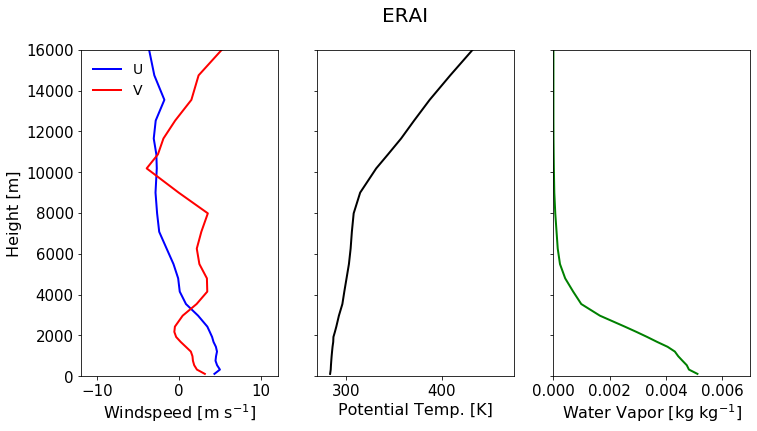

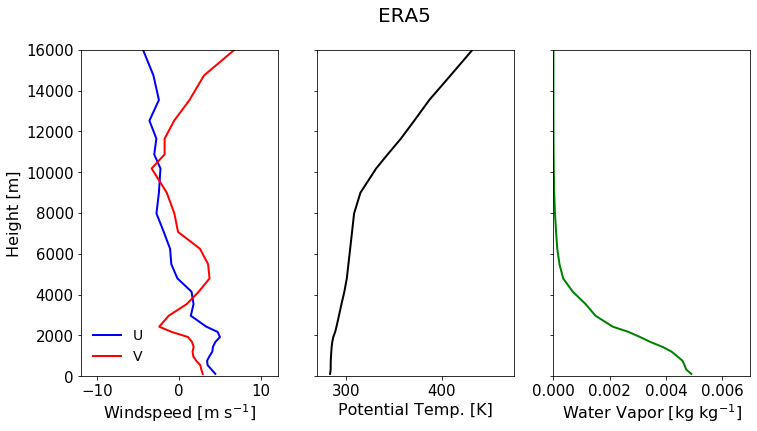

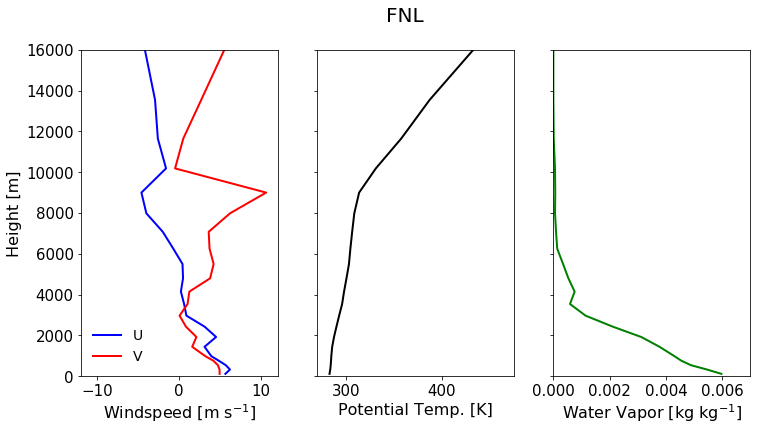

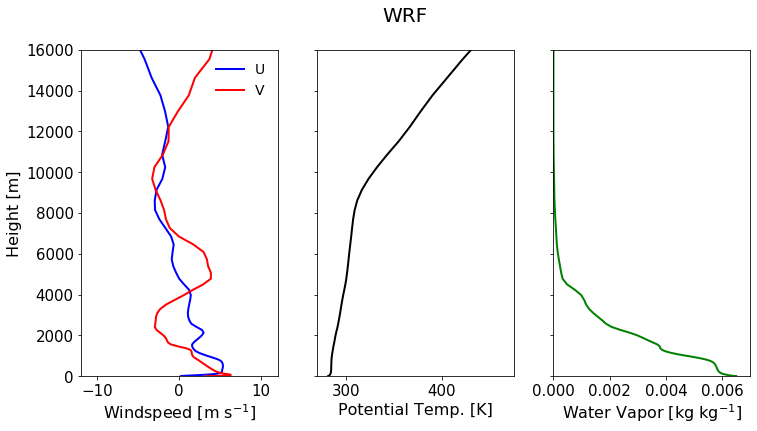

In [11]:
for input_type in input_types:
    ds = ds_dict[input_type].sel(datetime=initial_time)
    fig,ax = plt.subplots(ncols=3,figsize=(12,6),sharey=True)
    ax[0].plot(ds.U,ds.z,c='b',lw=2.0,label='U')
    ax[0].plot(ds.V,ds.z,c='r',lw=2.0,label='V')
    ax[0].set_xlabel('Windspeed [m s$^{-1}$]',size=16)
    ax[0].set_ylabel('Height [m]',size=16)
    ax[0].legend(frameon=False,fontsize=14)
    ax[0].set_xlim(-12,12)

    ax[1].plot(ds.theta,ds.z,c='k',lw=2.0)
    ax[1].set_xlabel('Potential Temp. [K]',size=16)
    ax[1].set_xlim(270,475)

    ax[2].plot(ds.QVAPOR,ds.z,c='g',lw=2.0)
    ax[2].set_xlabel('Water Vapor [kg kg$^{-1}$]',size=16)
    ax[2].set_xlim(0.0,0.007)

    for axi in range(0,3):
        ax[axi].tick_params(labelsize=15)
    plt.suptitle(input_type,size=20)
    plt.ylim(0,16000)
    plt.show()

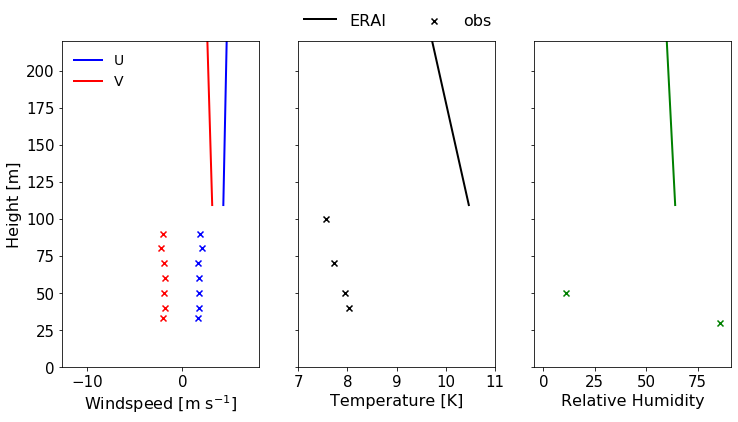

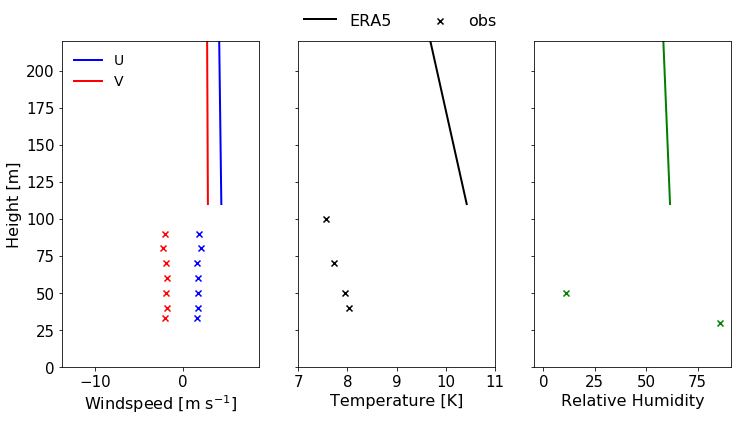

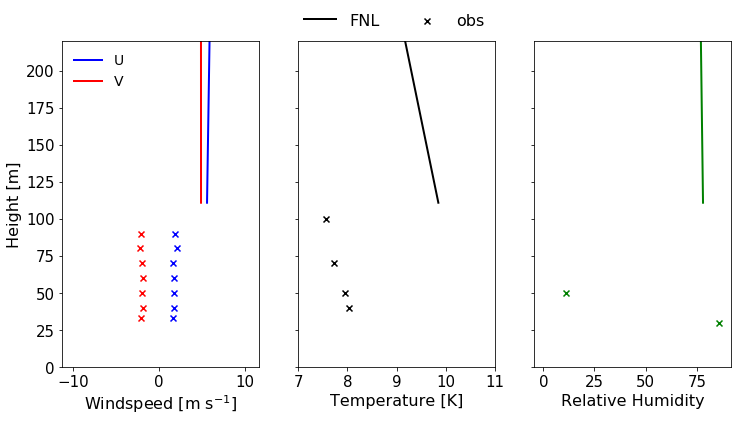

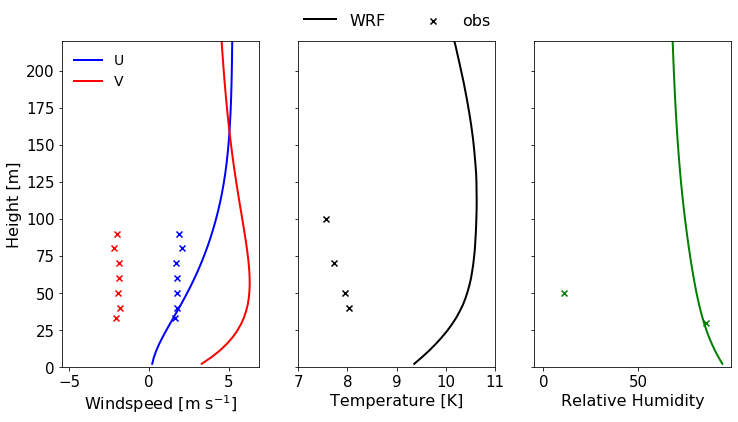

In [12]:
for input_type in input_types:
    ds = ds_dict[input_type].sel(datetime=initial_time)

    if 'PB' in ds.data_vars:
        pres = ds.P + ds.PB
    else:
        pres = ds.P
    
    if pres.max() > 2000: pres /= 100.0
    
    if 'theta' not in ds.data_vars:
        if input_type == 'WRF':
            temp = ds.T+300.0
        else:
            temp = ds.T
        ds['theta'] = calc_theta(temp,pres)

    if 'RH' not in ds.data_vars:
        if input_type == 'WRF':
            theta = ds.theta
        else:
            theta = ds.theta
            
        ds['RH'] = 100.0*(ds.QVAPOR / w_s(theta,pres))

    if input_type == 'WRF':
        temp = ds.Tc
    else:
        temp = ds.T - 273.15
    
    theta = ds['theta'] - 273.15
    
    init_obs = fino1.sel(datetime=initial_time)

    show_plots = True

    if show_plots:
        fig,ax = plt.subplots(ncols=3,figsize=(12,6),sharey=True)
        ax[0].plot(ds.U,ds.z,c='b',lw=2.0,label='U')
        ax[0].scatter(init_obs.U,init_obs.dir_levels,c='b',marker='x')
        ax[0].plot(ds.V,ds.z,c='r',lw=2.0,label='V')
        ax[0].scatter(init_obs.V,init_obs.dir_levels,c='r',marker='x')
        ax[0].set_xlabel('Windspeed [m s$^{-1}$]',size=16)
        ax[0].set_ylabel('Height [m]',size=16)
        ax[0].legend(frameon=False,fontsize=14)

        ax[1].plot(temp,ds.z,c='k',lw=2.0,
                   label=input_type)
        ax[1].set_xlabel('Temperature [K]',size=16)
        ax[1].scatter(init_obs.temp,init_obs.tmp_levels,c='k',
                      marker='x',label='obs')
        ax[1].set_xlim(7,11)

        ax[2].plot(ds.RH,ds.z,c='g',lw=2.0)
        ax[2].set_xlabel('Relative Humidity',size=16)
        ax[2].scatter(init_obs.rh,init_obs.rh_levels,c='g',marker='x')
        for axi in range(0,3):
            ax[axi].tick_params(labelsize=15)
        ax[0].set_ylim(0,220)
        ax[1].legend(frameon=False,loc=(0.0,1.02),ncol=2,fontsize=16)

In [13]:
for input_type in input_types:
    ds = ds_dict[input_type].sel(datetime=initial_time)

    if 'PB' in ds.data_vars:
        pres = ds.P + ds.PB
    else:
        pres = ds.P
    
    if pres.max() > 2000: pres /= 100.0
    
    if 'theta' not in ds.data_vars:
        if input_type == 'WRF':
            theta = ds.T+300.0
        else:
            theta = ds.T
        theta.name = 'theta'
        ds['theta'] = theta
        ds = ds.drop(['T'])
        ds['T'] = theta_to_T(theta,pres)

    if 'RH' not in ds.data_vars:
        theta = ds.theta
        ds['RH'] = 100.0*(ds.QVAPOR / w_s(theta,pres))

    if input_type == 'WRF':
        u10 = ds.U.sel(bottom_top=0).data
        v10 = ds.V.sel(bottom_top=0).data
    else:
        u10 = ds.U10.data
        v10 = ds.V10.data
    
    if ds.PSFC.max() < 2000:
        pres = ds.PSFC.data*100.0
    else:
        pres = ds.PSFC.data

    print('{0}{1}/input_sounding'.format(out_dir,input_type))
    CreateInputSounding(new_file_name='{0}{1}/input_sounding'.format(out_dir,input_type),
                        z=ds.z.data,
                        T=ds.theta.data,
                        Q=ds.QVAPOR.fillna(0.0).data, # QVAPOR
                        U=ds.U.data,
                        V=ds.V.data,
                        sfc_T=float(ds.T2.data),
                        sfc_Q=float(ds.Q2.data),
                        sfc_P=float(pres),
                        sfc_U=float(u10),
                        sfc_V=float(v10),
                        )

/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/ERAI/input_sounding
/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/ERA5/input_sounding
/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/FNL/input_sounding
/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/WRF/input_sounding


### Forcing File:

In [14]:
end_time = '2010-05-17 00:00:00'

for input_type in input_types:

    mean_forcing_ds = ds_dict[input_type].sel(datetime=slice(initial_time,end_time))

    if 'W' not in mean_forcing_ds.data_vars:
        w = mean_forcing_ds.V.data * 0.0
    else:
        w = mean_forcing_ds.W.data
        
    z = mean_forcing_ds.z.data
    Ug = mean_forcing_ds.U.data
    Vg = mean_forcing_ds.V.data

    
    if z[0,0] > 5:
        bot = np.zeros(len(mean_forcing_ds.datetime.data))
        z = np.vstack((bot,z.T)).T
        Ug = np.vstack((bot,Ug.T)).T
        Vg = np.vstack((bot,Vg.T)).T
        w = np.vstack((bot,w.T)).T


    CreateForcingFile(new_file_name='{}{}/FINO_forcing.txt'.format(out_dir,input_type),
                      z=z,
                      Ug=Ug,
                      Vg=Vg,
                      W=w,
                      datetime=list(mean_forcing_ds.datetime.data))

### Check input soundings:

In [15]:
def read_input_sounding(f_name):
    f = open(f_name)
    z,u,v,T,q = [],[],[],[],[]
    f.readline()
    for line in f:
        line = line.split()
        z += [float(line[0])]
        u += [float(line[1])]
        v += [float(line[2])]
        T += [float(line[3])]
        q += [float(line[4])]
    return(z,u,v,T,q)

In [18]:
sounding_dict = {#'good':{'c':'k'},
                 'WRF':{'c':'m'},
                 'FNL':{'c':'g'},
                 'ERAI':{'c':'b'},
                 'ERA5':{'c':'darkred'},
                }

variable_dict = {'z':0,
                 'u':1,
                 'v':2,
                 'T':3,
                 'q':4,
                }

for key in list(sounding_dict.keys()):
    data = read_input_sounding('/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/input_sounding_{}'.format(key))
    for varn in list(variable_dict.keys()):
        sounding_dict[key][varn] = data[variable_dict[varn]]


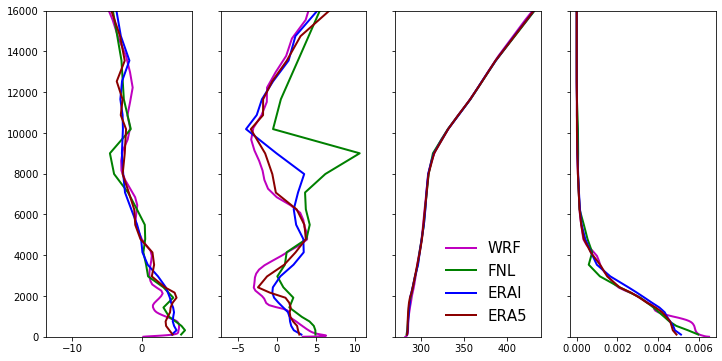

In [19]:
fig,ax = plt.subplots(ncols=4,figsize=(12,6),sharey=True)
for key in list(sounding_dict.keys()):
    for vv,varn in enumerate(list(variable_dict.keys())[1:]):
        ax[vv].plot(sounding_dict[key][varn],sounding_dict[key]['z'],
                    c=sounding_dict[key]['c'],label=key,lw=2.0)
    ax[2].legend(frameon=False,fontsize=15)
    ax[0].set_ylim(0,16000)
    ax[2].set_xlim(270,440)
plt.show()


***

<div class="alert alert-block alert-warning">
<b>STOP! </b>

    
You have now created forcing files, input soundings, and input soils for each of the ICBCs.
    
Stop here and run WRF for each of these and save the wrfout files in unique directories.
    The structure of which is explained below:
</div>

run_dir = /glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/

cases in: 

    [run_dir]/ERAI/[all the data]
    [run_dir]/ERA5/[all the data]
    [run_dir]/FNL/[all the data]
***

# Check results:

In [66]:
ml_dir = '/glade/scratch/hawbecke/WRF/MMC/ML-SL/FINO/'

cases = icbc_types + ['WRF']

sim_dict = {'wrfout_d01_MO':{'name':'M-O','color':'b'},
            'wrfout_d01_RF':{'name':'RF','color':'r'}}
sim_names = list(sim_dict.keys())

#case_dict = {'no_forcing':{'case_str':'No Forcing'},
#             'geo_only':{'case_str':'Ug and Vg only'},
#             }
#cases = list(case_dict.keys())

In [70]:
init_ds = True
#for input_type in input_types:
for cc,case in enumerate(cases):
    f_dir = '{}{}/'.format(ml_dir,case)
    for sim in sim_names:
        print(case,sim)
        wrf_ds = xr.open_dataset('{}/{}'.format(f_dir,sim))
        wrf_ds = wrf_ds.mean(dim=['south_north','south_north_stag','west_east','west_east_stag'])
        if init_ds:
            good_vars = []
            for varn in list(wrf_ds.data_vars):
                if 'seed_dim_stag' not in list(wrf_ds[varn].dims):
                    good_vars += [varn]
        wrf_ds = wrf_ds[good_vars]
        wrf_ds['wspd'] = (wrf_ds.U**2 + wrf_ds.V**2)**0.5
        wrf_ds['zs'] = (wrf_ds.PH + wrf_ds.PHB)/9.81 - wrf_ds.HGT
        z = 0.5*(wrf_ds.zs.sel(bottom_top_stag=slice(1,len(wrf_ds.bottom_top_stag))) +
                 wrf_ds.zs.sel(bottom_top_stag=slice(0,len(wrf_ds.bottom_top_stag)-1)))
        z = z.rename({'bottom_top_stag':'bottom_top'})
        wrf_ds['z'] = z
        wrf_ds['datetime'] = [pd.to_datetime(str(t).replace('_',' ')) for t in wrf_ds.XTIME.data]

        vars_to_get = ['datetime']
        for varn in wrf_ds.data_vars:
            if len(wrf_ds[varn].dims) == 3:
                vars_to_get += [varn]
            elif len(wrf_ds[varn].dims) == 4:
                if 'bottom_top' in wrf_ds[varn].dims:
                    vars_to_get += [varn]
                if 'bottom_top_stag' in wrf_ds[varn].dims:
                    vars_to_get += [varn]

        
        wrf_ds = wrf_ds[vars_to_get]
        
        wrf_ds = wrf_ds.expand_dims({'case':[case],'sim':[sim_dict[sim]['name']]})
        
        if init_ds:
            wrf_ds_f = wrf_ds.copy()
            init_ds = False
        else:
            wrf_ds_f = xr.merge([wrf_ds_f,wrf_ds])

wrf_ds_f['temp'] = theta_to_T(wrf_ds_f.T+300.0,(wrf_ds_f.P+wrf_ds_f.PB)/100.0) - 273.15

ERAI wrfout_d01_MO
ERAI wrfout_d01_RF
ERA5 wrfout_d01_MO
ERA5 wrfout_d01_RF
FNL wrfout_d01_MO
FNL wrfout_d01_RF
WRF wrfout_d01_MO
WRF wrfout_d01_RF


AttributeError: 'Dataset' object has no attribute 'T'

AttributeError: 'Dataset' object has no attribute 'datetime'

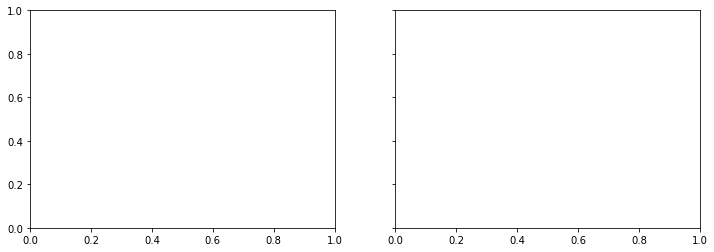

In [68]:
for cc,case in enumerate(cases):
    row,col = 0,0
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,4),sharex=True,sharey=True)
    for ss,sim in enumerate(wrf_ds_f.sim):
        wrf_ds = wrf_ds_f.sel(case=case,sim=sim)
        wspd_plt = ax[col].pcolormesh(wrf_ds.datetime,wrf_ds.z.mean(dim=['Time']),wrf_ds.wspd.T,
                                      #vmin=wrf_ds_f.wspd.sel(case=case).min(),vmax=wrf_ds_f.wspd.sel(case=case).max())
                                      #vmin=0,vmax=8
                                     )
        ax[col].set_title('{} - {}'.format(str(sim.data),case),size=18)
        col += 1
        if col == 2:
            col = 0
            row += 1

    nlabels = 9
    labels = pd.date_range(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1],periods=nlabels)
    labels_str = ['{0:02d} {1:02d}:{2:02d}'.format(lbl.day,lbl.hour,lbl.minute) for lbl in labels]


    for col in range(0,2):
        ax[col].set_ylim(0,2000)
        ax[col].tick_params(labelsize=15)
        ax[col].tick_params(axis='x',rotation=35)
        ax[col].set_xticks(labels)
        ax[col].set_xticklabels(labels=labels_str,ha='right')

    cax  = fig.add_axes([0.925,0.125,0.02,0.755])
    cbar = plt.colorbar(wspd_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.show()

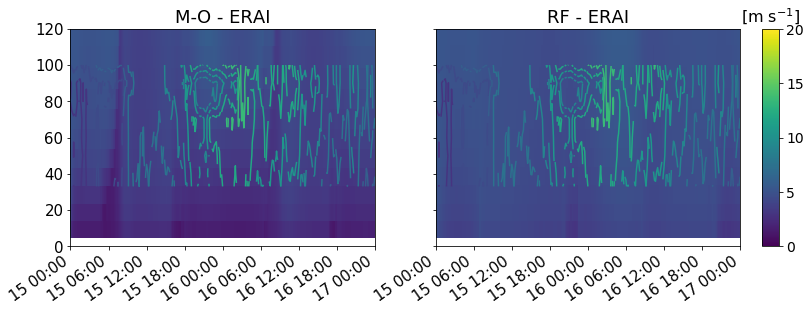

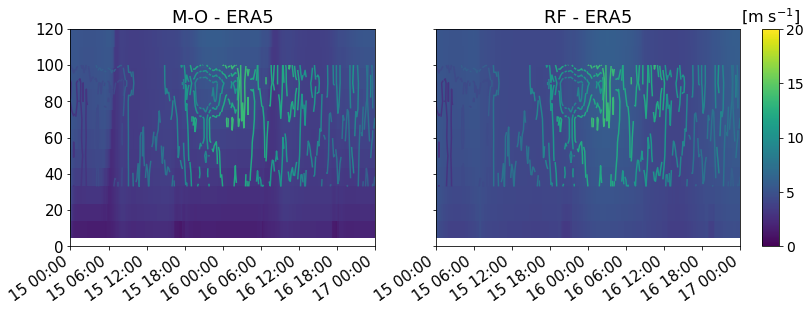

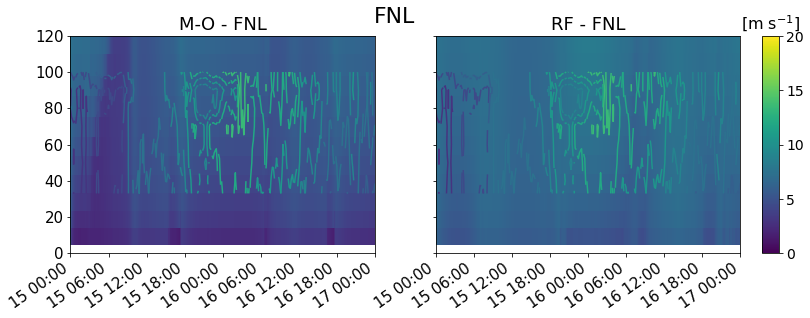

In [44]:
for cc,case in enumerate(cases):
    row,col = 0,0
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,4),sharex=True,sharey=True)
    for ss,sim in enumerate(wrf_ds_f.sim):
        wrf_ds = wrf_ds_f.sel(case=case,sim=sim)
        wspd_plt = ax[col].pcolormesh(wrf_ds.datetime,wrf_ds.z.mean(dim=['Time']),wrf_ds.wspd.T,
                                      #vmin=wrf_ds_f.wspd.sel(case=case).min(),vmax=wrf_ds_f.wspd.sel(case=case).max())
                                      vmin=0,vmax=20)
        ax[col].set_title('{} - {}'.format(str(sim.data),case),size=18)

        ax[col].contour(pd.to_datetime(fino1.datetime.data),
                        fino1.spd_levels,
                        fino1.wspd,
                        vmin=0,vmax=20,
                        )


        col += 1
        if col == 2:
            col = 0
            row += 1

    nlabels = 9
    labels = pd.date_range(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1],periods=nlabels)
    labels_str = ['{0:02d} {1:02d}:{2:02d}'.format(lbl.day,lbl.hour,lbl.minute) for lbl in labels]


    for col in range(0,2):
        ax[col].set_ylim(0,120)
        ax[col].tick_params(labelsize=15)
        ax[col].tick_params(axis='x',rotation=35)
        ax[col].set_xticks(labels)
        ax[col].set_xticklabels(labels=labels_str,ha='right')

    cax  = fig.add_axes([0.925,0.125,0.02,0.755])
    cbar = plt.colorbar(wspd_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.suptitle(input_type,size=22)
plt.show()

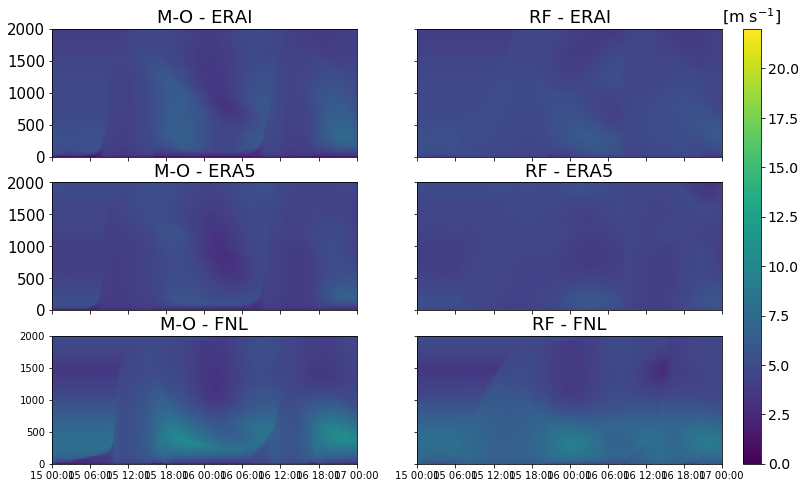

In [47]:
fig,ax = plt.subplots(ncols=2,nrows=len(cases),figsize=(12,8),sharex=True,sharey=True)
row,col = 0,0

for cc,case in enumerate(cases):
    for ss,sim in enumerate(wrf_ds_f.sim):
        wrf_ds = wrf_ds_f.sel(case=case,sim=sim)
        vmin = 0 # wrf_ds_f.wspd.sel(case=case).min()
        vmax = 22 # wrf_ds_f.wspd.sel(case=case).max()
        wspd_plt = ax[row,col].pcolormesh(wrf_ds.datetime,wrf_ds.z.mean(dim=['Time']),wrf_ds.wspd.T,
                                          vmin=vmin,vmax=vmax)
        ax[row,col].set_title('{} - {}'.format(str(sim.data),case),size=18)

        #obs_time = pd.to_datetime(obs_ds.time.data)
        #obs_height = obs_ds.zf_index.isel(time=0)
        #obs_wspd = (obs_ds.u**2 + obs_ds.v**2)**0.5
        #ax[row,col].contour(obs_time,obs_height,obs_wspd.T,
        #                levels=np.arange(vmin,vmax+0.1,2.0))
        col += 1
        if col == 2:
            col = 0
            row += 1

nlabels = 9
labels = pd.date_range(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1],periods=nlabels)
labels_str = ['{0:02d} {1:02d}:{2:02d}'.format(lbl.day,lbl.hour,lbl.minute) for lbl in labels]

for row in range(0,2):
    for col in range(0,2):
        ax[row,col].set_ylim(0,2000)
        ax[row,col].tick_params(labelsize=15)
        ax[row,col].tick_params(axis='x',rotation=35)
        ax[row,col].set_xticks(labels)
        ax[row,col].set_xticklabels(labels=labels_str,ha='right')

cax  = fig.add_axes([0.925,0.125,0.02,0.755])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.show()

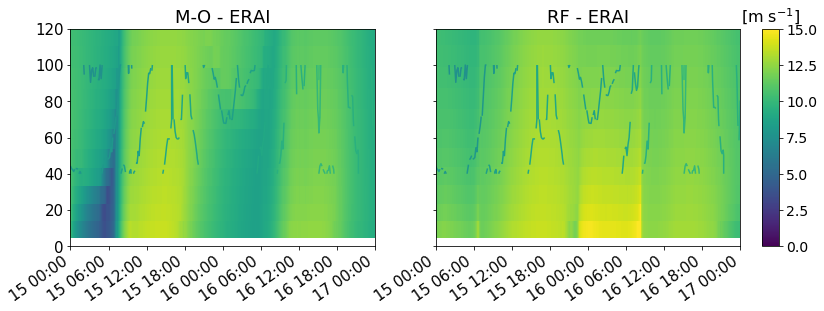

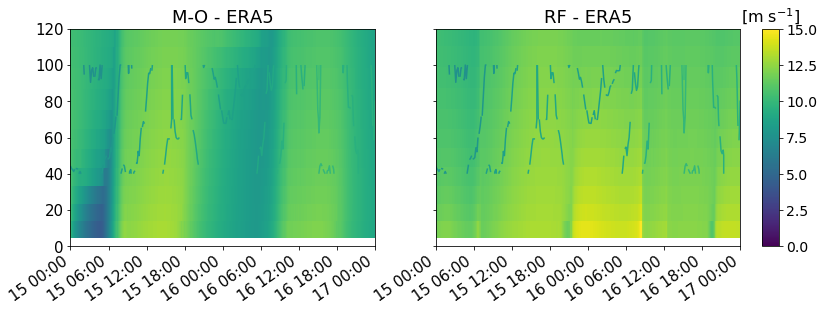

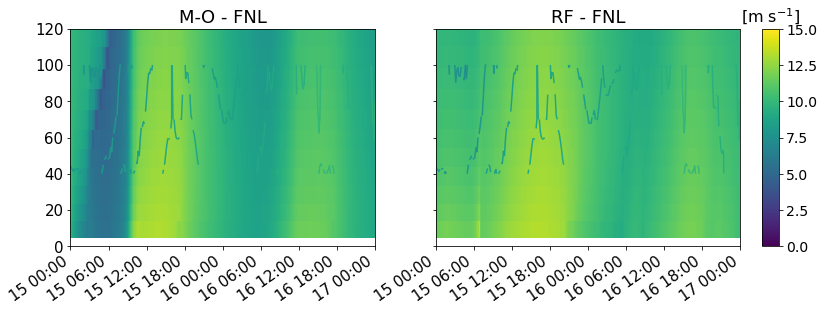

In [48]:
for cc,case in enumerate(cases):
    row,col = 0,0
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,4),sharex=True,sharey=True)
    for ss,sim in enumerate(wrf_ds_f.sim):
        wrf_ds = wrf_ds_f.sel(case=case,sim=sim)
        wspd_plt = ax[col].pcolormesh(wrf_ds.datetime,wrf_ds.z.mean(dim=['Time']),wrf_ds.temp.T,
                                      #vmin=wrf_ds_f.wspd.sel(case=case).min(),vmax=wrf_ds_f.wspd.sel(case=case).max())
                                      vmin=0,vmax=15,
                                      )
        ax[col].set_title('{} - {}'.format(str(sim.data),case),size=18)

        ax[col].contour(pd.to_datetime(fino1.datetime.data),
                        fino1.tmp_levels,
                        fino1.temp,
                        vmin=0,vmax=15,
                        )


        col += 1
        if col == 2:
            col = 0
            row += 1

    nlabels = 9
    labels = pd.date_range(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1],periods=nlabels)
    labels_str = ['{0:02d} {1:02d}:{2:02d}'.format(lbl.day,lbl.hour,lbl.minute) for lbl in labels]


    for col in range(0,2):
        ax[col].set_ylim(0,120)
        ax[col].tick_params(labelsize=15)
        ax[col].tick_params(axis='x',rotation=35)
        ax[col].set_xticks(labels)
        ax[col].set_xticklabels(labels=labels_str,ha='right')

    cax  = fig.add_axes([0.925,0.125,0.02,0.755])
    cbar = plt.colorbar(wspd_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    plt.show()

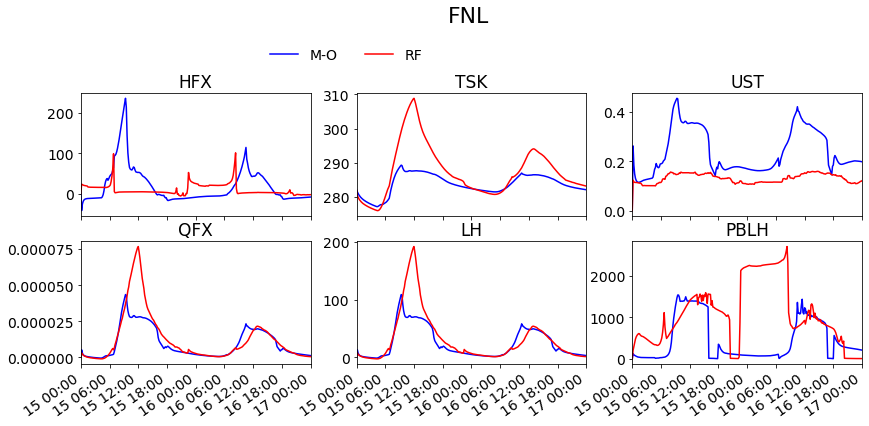

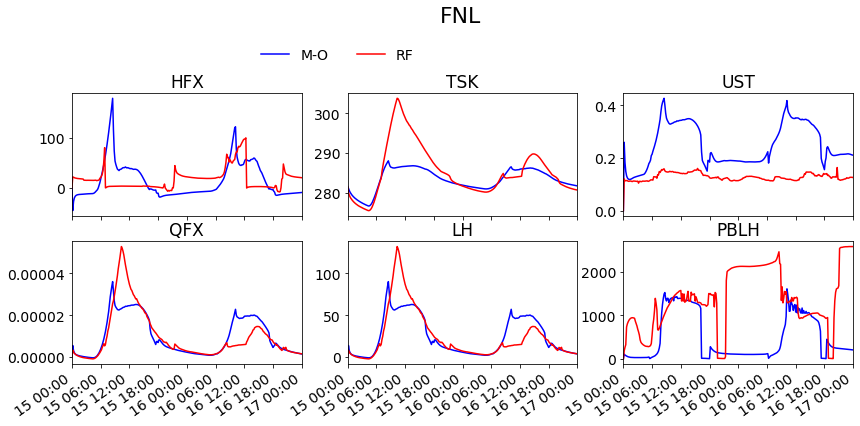

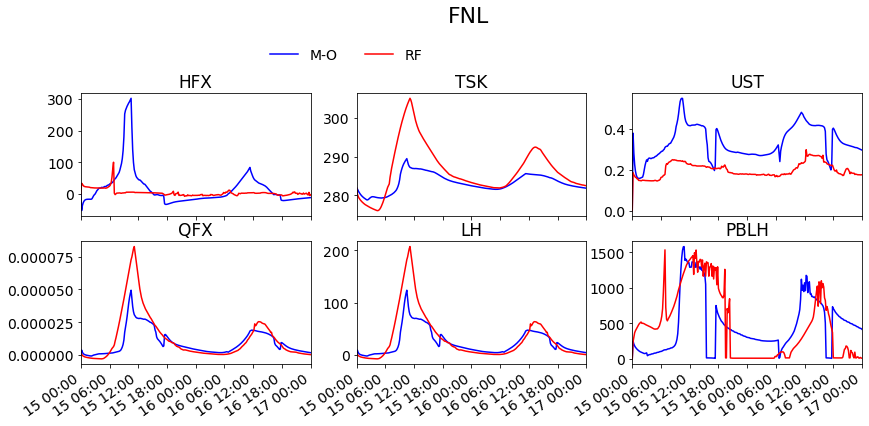

In [51]:
plt_vars = ['HFX','TSK','UST','QFX','LH','PBLH']
ncol = 3
nrow = 2

for cc,case in enumerate(cases):
    fig,ax = plt.subplots(ncols=ncol,nrows=nrow,figsize=(14,5),sharex=True)

    row,col = 0,0

    for ss,sim in enumerate(sim_names):
        row,col = 0,0
        for varn in plt_vars:
            ls = '-'
            wrf_ds = wrf_ds_f.sel(case=case,sim=sim_dict[sim]['name'])
            ax[row,col].plot(wrf_ds.datetime,wrf_ds[varn],
                             label='{}'.format(sim_dict[sim]['name']),
                             ls=ls,c=sim_dict[sim]['color'])
            ax[row,col].set_title(varn,size=17)

            col += 1
            if col == ncol:
                col = 0
                row += 1

    for row in range(0,2):
        for col in range(0,3):
            ax[row,col].set_xlim(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1])
            ax[row,col].tick_params(labelsize=14)
            ax[row,col].tick_params(axis='x',rotation=35)
            ax[row,col].set_xticks(labels)
            ax[row,col].set_xticklabels(labels=labels_str,ha='right')
    ax[0,1].legend(frameon=False,fontsize=14,ncol=2,loc=(-0.4,1.2))
    plt.suptitle(input_type,size=22,y=1.12,x=0.51)
    plt.show()

In [52]:
obs_dir = '/glade/work/hawbecke/MMC/FINO/'
obs_ds = xr.open_dataset('{}FINO1_obs.nc'.format(obs_dir))
obs_ds = obs_ds.sel(datetime=slice(wrf_ds_f.datetime[0],wrf_ds_f.datetime[-1]))

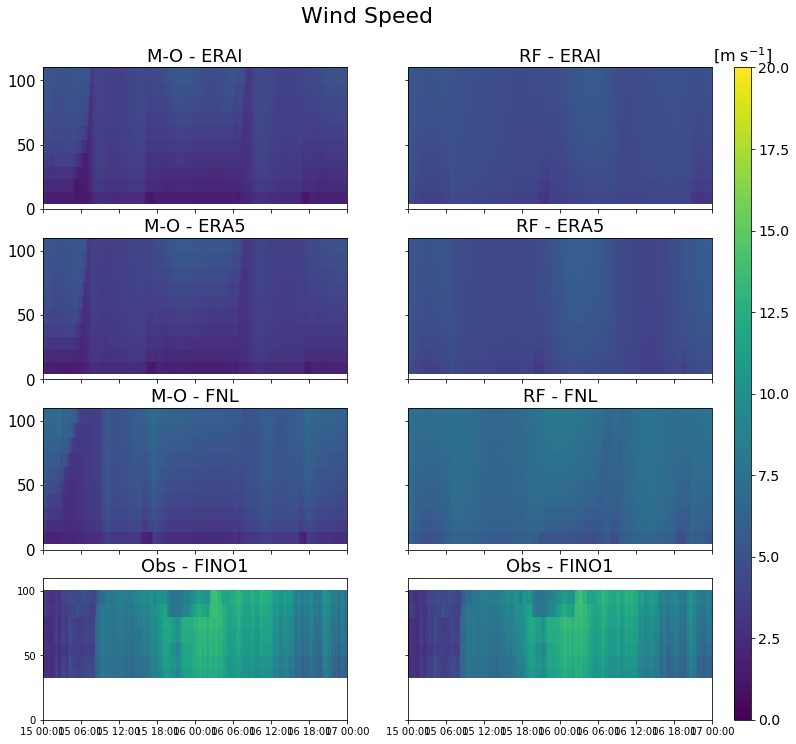

In [56]:
fig,ax = plt.subplots(ncols=2,nrows=4,figsize=(12,12),sharex=True,sharey=True)

row,col = 0,0

for cc,case in enumerate(cases + ['obs']):
    for ss,sim in enumerate(wrf_ds_f.sim):
        if case != 'obs':
            wrf_ds = wrf_ds_f.sel(case=case,sim=sim)
            plt_time = wrf_ds.datetime
            plt_z = wrf_ds.z.mean(dim=['Time'])
            plt_wspd = wrf_ds.wspd.T
            sim_str,case_str = str(sim.data),case
        else:
            plt_time = fino1.datetime
            plt_z = fino1.spd_levels
            plt_wspd = fino1.wspd
            sim_str,case_str = 'Obs','FINO1'
        wspd_plt = ax[row,col].pcolormesh(plt_time,plt_z,plt_wspd,
                                          #vmin=wrf_ds_f.wspd.min(),vmax=wrf_ds_f.wspd.max())
                                          vmin=0,vmax=20)

        ax[row,col].set_title('{} - {}'.format(sim_str,case_str),size=18)
        col += 1
        if col == 2:
            col = 0
            row += 1
            
nlabels = 9
labels = pd.date_range(wrf_ds.datetime.data[0],wrf_ds.datetime.data[-1],periods=nlabels)
labels_str = ['{0:02d} {1:02d}:{2:02d}'.format(lbl.day,lbl.hour,lbl.minute) for lbl in labels]

for row in range(0,3):
    for col in range(0,2):
        ax[row,col].set_ylim(0,110)
        ax[row,col].tick_params(labelsize=15)
        ax[row,col].tick_params(axis='x',rotation=35)
        ax[row,col].set_xticks(labels)
        ax[row,col].set_xticklabels(labels=labels_str,ha='right')
        
cax  = fig.add_axes([0.925,0.125,0.02,0.755])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.suptitle('Wind Speed',size=22,y=0.95)
plt.show()